In [ ]:
import pathlib
import numpy as np
from scipy import stats, signal, fft
from scipy.optimize import curve_fit
from scipy.ndimage import convolve
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from PIL import Image

## Data-Handling

In [224]:
DATA_DIR = 'datasets_for_Statistician/Latent4_06_Jul_2023_6'
# DATA_DIR = 'data_map_cutouts/train_50_2_npy/Primary_train/generated_data/'
BATCH_SIZE = 256
TOTAL_NO_IMAGES = 400

## Visualization

Shape of images from dataLoader: (128, 128)


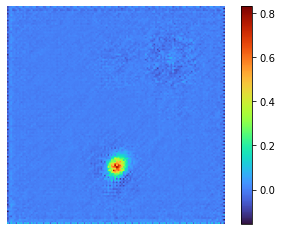

In [229]:

# Sampling from the dataset
image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
# plt.figure(figsize=(100,100))
# image_indx = 47
image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

images = np.load(image_path)
# images = cv2.GaussianBlur(images, (3,3), 0)


print("Shape of images from dataLoader:", images.shape)

# Displaying a sample input image
plt.imshow(images, cmap = 'turbo')
plt.axis('off')
plt.colorbar()
plt.show()

## Plotting the Intensity distribution

(16384, 128)


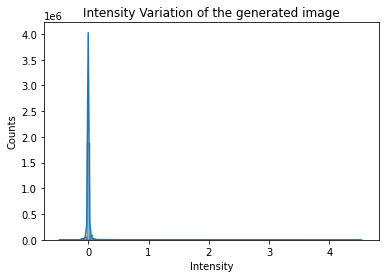

In [230]:
# image_indx = np.random.randint(0, TOTAL_NO_IMAGES)

image_path = DATA_DIR + '/' + str(0) + '.npy'
images = np.load(image_path)


for i in range(127):
    image_indx = i
    image_path = DATA_DIR + '/' + str(image_indx) + '.npy'
    temp_images = np.load(image_path)

    images = np.concatenate([images, temp_images], axis = 0)
print(images.shape)

# images = np.abs(images)

# images = images.detach().cpu().numpy()
images = np.reshape(images, (-1,))

# Use seaborn to plot the intensity distribution
sns.histplot(images, kde=True, binwidth=0.05)

# Set plot labels
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title("Intensity Variation of the generated image")
# plt.xlim([0, 1.])
# Show the plot
plt.show()

## Plotting the marginal distributions

In [248]:
# Define the Gaussian function
def gaussian_with_mean(x, amplitude, mean, variance):
    return amplitude * np.exp(-(np.abs(x - mean) ** 2) / (2 * variance))

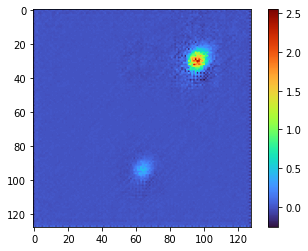

----Best-fit parameters---
Amplitude: -0.5541520169884873
Mean: 5.032169621790283
Variance: 19.144199421829764


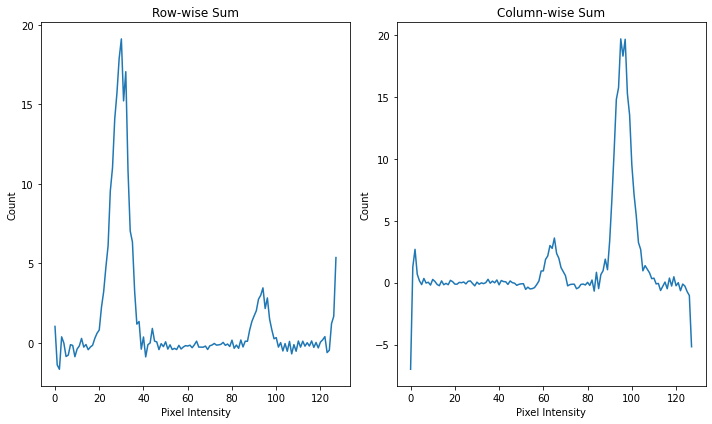

In [258]:
# image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

image = np.load(image_path)
# images = cv2.GaussianBlur(images, (7,7), 0)


# Calculate the row-wise and column-wise histograms
row_hist = np.sum(image, axis=1)
col_hist = np.sum(image, axis=0)

plt.imshow(image, cmap='turbo')
plt.colorbar()
plt.show()

# Create subplots for row and column histograms
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot row-wise histogram
axes[0].plot(row_hist)
x = np.arange(row_hist.size)
        # print(x, intensity_maps)

        # Fit the Gaussian curve to the data
initial_guess = [1, 0., 10]  # Initial parameter guesses for the fit
        # try:
optimized_parameters, _ = curve_fit(gaussian_with_mean, x, row_hist, p0=initial_guess, maxfev=1000000)

                # Extract the optimized parameter values
amplitude_opt, mean_opt, var_opt = optimized_parameters
print("----Best-fit parameters---")
print("Amplitude:", amplitude_opt)
print("Mean:", mean_opt)
print("Variance:", var_opt)

                # Generate the best-fit Gaussian curve using the optimized parameters
y_fit = gaussian_with_mean(x, amplitude_opt, mean_opt, var_opt)
                
# axes[0].plot(y_fit)
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Count')
axes[0].set_title('Row-wise Sum')

# Plot column-wise histogram
axes[1].plot(col_hist)
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Count')
axes[1].set_title('Column-wise Sum')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Counting the average number of peaks per image

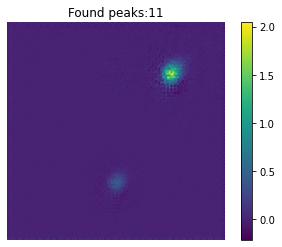

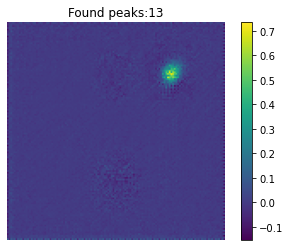

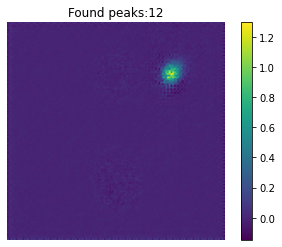

Found: 2950


In [233]:
from skimage.feature import peak_local_max
# images, _ = next(iter(dataLoader))
# images = images.detach().cpu().numpy()

peak_area_list = []
for i in range(BATCH_SIZE):

    # Need to remove the streaks

    image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
    image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

    image = np.load(image_path)

    # grey = cv2.convertScaleAbs(image * 255)

    # _, binary = cv2.threshold(grey, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # # Perform morphological operations to remove streaks
    # kernel = np.ones((7,7), np.uint8)
    # opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # # Invert the binary image to create a mask for the streaks
    # mask = 255 - opening
    # # Apply the mask to the original image
    # result = cv2.bitwise_and(grey, grey, mask=mask)

    
    
    # Define the minimum peak height and minimum distance between peaks
    min_peak_height = 0.
    min_peak_distance = 10

    # Find all the peaks in the image
    peaks = peak_local_max(image=image - np.min(image), 
                           min_distance=min_peak_distance, 
                           threshold_abs=min_peak_height)
    for peak in peaks:
        min_x = peak[0] - 10
        min_y = peak[1] - 10
        max_x = peak[0] + 11
        max_y = peak[1] + 11
        
        peak_area_list.append(image[min_x:max_x, min_y:max_y])

    if i % 100 == 0:
        # plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title("Found peaks:" + str(peaks.shape[0]))
        plt.axis('off')
        plt.colorbar()

        # plt.subplot(1,2,2)
        # plt.imshow(grey)
        # plt.axis('off')
        # plt.colorbar()
        plt.show()


print("Found:", len(peak_area_list))

In [ ]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

image = np.load(DATA_DIR + '/123.npy')

_, _, sigma = sigma_clipped_stats(image, sigma=1.50)
daofind = DAOStarFinder(fwhm=3.0, threshold=5*sigma)  
sources = daofind(image) 
print(sources)

In [ ]:
x = np.linspace(0, 1, 128)
y = np.linspace(0, 1, 128)
X, Y = np.meshgrid(x, y)
a = np.vstack((X.ravel(), Y.ravel())).T
def make_blob(mean, var=1):
    return stats.multivariate_normal.pdf(a, mean=mean, cov=var * 1e-3).reshape((128, 128))

filter_gaussian = make_blob((0.5, 0.5))
filter_gaussian = filter_gaussian / np.max(filter_gaussian)
plt.figure(dpi=150)
plt.subplot(2,2,1)
plt.imshow(image, cmap='turbo')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(filter_gaussian, cmap='turbo')
plt.colorbar()

image_temp = np.copy(image)

peak_pos = []
count = 0

while np.max(image_temp > 0.5) and count < 50:
    count += 1
    print(f'\r{count}/50, {np.max(image_temp)}', end='')
    result = convolve(image_temp, filter_gaussian, mode = 'constant', cval=0.)
    pos_max = np.argmax(result)
    x = pos_max // 128
    y = pos_max % 128
    peak_pos.append([x,y])
    a_max = result[x,y] / 52.26614518050251
    a_max = image_temp[x, y]

    to_remove = make_blob((y/128, x/128))
    to_remove = to_remove / np.max(to_remove)
    to_remove = to_remove * a_max

    image_temp = image_temp - to_remove

plt.subplot(2,2,3)
plt.imshow(result, cmap='turbo')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(image_temp, cmap='turbo')
plt.colorbar()
plt.show()

print(count)

In [ ]:
peak_pos.sort()
for [x,y] in peak_pos:
    print(x,y)

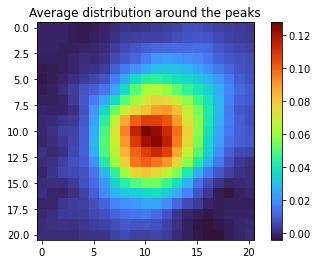

In [234]:
peak_avg = np.zeros((21, 21))
if len(peak_area_list) > 0: 
    for peak_area in peak_area_list:
        peak_avg += peak_area

    peak_avg = cv2.GaussianBlur(peak_avg, (3,3), 0)
    plt.imshow(peak_avg/len(peak_area_list), cmap='turbo')
else:
    plt.imshow(peak_avg)
plt.colorbar()
plt.title("Average distribution around the peaks")
plt.show()

In [235]:
# Define the Gaussian function
def gaussian(x, amplitude, variance):
    return amplitude * np.exp(-((x) ** 2) / (2 * variance))


In [236]:
def get_radial_dist(image = np.ones((21,21)), width=21, title='Intensity variation', best_fit=True):
    center = np.array([(width + 1) //2, (width + 1) // 2])
    # print("Center:", center)

    intensity_map = np.zeros(shape=(int(np.ceil(((width + 1 )// 2) * np.sqrt(2)))))
    counts = np.copy(intensity_map)

    for i in range(width):
        for j in range(width):
            pos = np.array([i, j])
            # print(pos)
            radius = int(np.linalg.norm(center - pos))
            # print(radius)
            intensity_map[radius] += image[i, j]
            counts[radius] += 1
    
    intensity_map = intensity_map / counts


    plt.plot(intensity_map)
    
    if best_fit:
        x = np.arange(intensity_map.size)
        # print(x, intensity_maps)

        # Fit the Gaussian curve to the data
        initial_guess = [1, 1.]  # Initial parameter guesses for the fit
        # try:
        optimized_parameters, _ = curve_fit(gaussian, x, intensity_map - np.min(intensity_map), p0=initial_guess, maxfev=1000000)

                # Extract the optimized parameter values
        amplitude_opt, var_opt = optimized_parameters
        print("----Best-fit parameters---")
        print("Amplitude:", amplitude_opt)
        # print("Mean:", mean_opt)
        print("Variance:", var_opt)

                # Generate the best-fit Gaussian curve using the optimized parameters
        y_fit = gaussian(x, amplitude_opt, var_opt) + np.min(intensity_map)
                
        plt.plot(y_fit)
        # except:
        #     print("ERROR: Best-fit Gaussian not found")
        # print(counts[0], counts[-1])
        plt.legend(['True intensity variation', 'Best-fit Gaussian'])
    plt.title(title)
    plt.show()

    return intensity_map

----Best-fit parameters---
Amplitude: 0.12179350516762147
Variance: 11.340873157029844


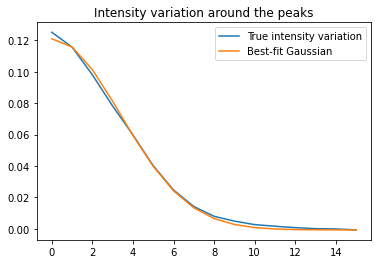

array([ 1.25251293e-01,  1.15774243e-01,  9.81298626e-02,  7.81841739e-02,
        5.98224062e-02,  4.02108308e-02,  2.47488881e-02,  1.42038526e-02,
        7.98110310e-03,  4.91514768e-03,  2.68490058e-03,  1.65505505e-03,
        7.62860582e-04,  9.86158689e-05, -7.02163145e-05, -6.90048772e-04])

In [237]:
get_radial_dist(peak_avg / len(peak_area_list), title='Intensity variation around the peaks')

In [238]:
print("Average no. of peaks per image:", len(peak_area_list)/BATCH_SIZE)

Average no. of peaks per image: 11.5234375


In [239]:
# Clean-up
del peak_area_list, peak_avg, peak, peak_area, peaks

## Image fft

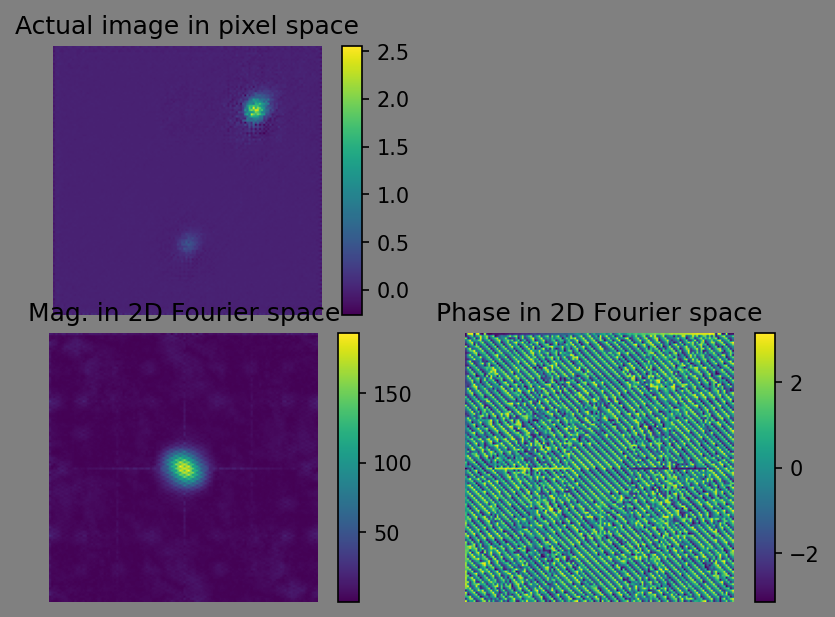

In [255]:
image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

image = np.load(image_path)

# images = images - np.mean(images)

images_fft = fft.fftshift(fft.fft2(image))

images_fft_abs = np.abs(images_fft)

images_fft_abs[np.angle(images_fft) < -np.pi / 2] *= -1
images_fft_abs[np.angle(images_fft) > np.pi / 2] *= -1

plt.figure(constrained_layout = True, dpi=150, facecolor='0.5')

# images_fft_abs = np.sum(images_fft_abs, axis=0)
plt.subplot(2,2,1)
plt.imshow(image)
plt.colorbar()
plt.title("Actual image in pixel space")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow((np.abs(images_fft[ :, :])))
plt.colorbar()
plt.title("Mag. in 2D Fourier space")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(np.angle(images_fft[:, :]))
plt.colorbar()
plt.title("Phase in 2D Fourier space")
plt.axis('off')

plt.show()

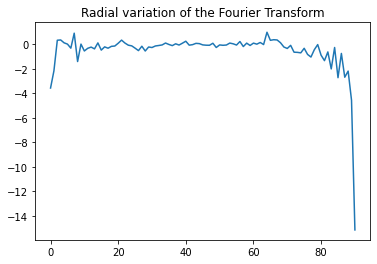

array([-3.57032108e+00, -2.16721857e+00,  3.28073621e-01,  3.51419425e-01,
        1.17655317e-01,  1.27370238e-02, -3.17527437e-01,  9.03385498e-01,
       -1.40967367e+00,  1.20431525e-02, -5.47431969e-01, -3.30085921e-01,
       -2.31864619e-01, -3.76217168e-01,  1.08480180e-01, -4.77097871e-01,
       -2.13099160e-01, -3.21801907e-01, -1.70243685e-01, -1.44464872e-01,
        8.15603109e-02,  3.37717565e-01,  9.81409813e-02, -7.61040164e-02,
       -1.30202934e-01, -3.17195327e-01, -5.17928565e-01, -1.62048510e-01,
       -5.50235757e-01, -2.23634954e-01, -2.66042381e-01, -1.40001797e-01,
       -1.01172355e-01, -5.48631052e-02,  1.00478197e-01, -1.74389605e-02,
       -1.11198759e-01,  3.72421660e-02, -6.40524520e-02,  8.80019656e-02,
        2.47379694e-01, -7.35674886e-02, -3.21416008e-02,  7.36411062e-02,
        5.22011176e-02, -5.16744705e-02, -7.70295858e-02, -8.25767192e-02,
        8.12215522e-02, -2.63016349e-01, -5.52887811e-02, -8.41711267e-02,
       -6.25497304e-02,  

In [241]:
get_radial_dist(image = images_fft_abs[:, :], 
                width = 128, 
                best_fit = False, 
                title = 'Radial variation of the Fourier Transform')

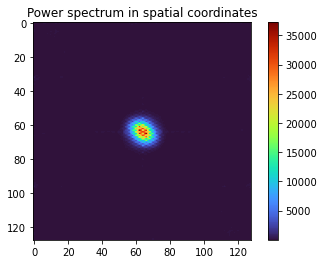

In [256]:
power_spectrum = np.abs(np.conj(images_fft) * images_fft)
plt.imshow((power_spectrum[:, :]), cmap='turbo')
plt.colorbar()
plt.title("Power spectrum in spatial coordinates")
plt.show()

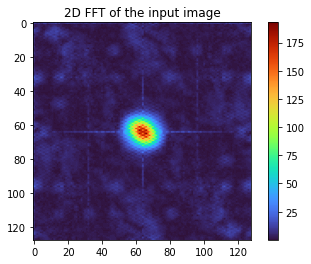

In [257]:
plt.imshow(np.abs(images_fft), cmap='turbo')
plt.title("2D FFT of the input image")
plt.colorbar()
plt.show()